In [1]:
import os
import torch
torch.manual_seed(42) # Set arbitrary seed
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler # Needed to construct the validation set
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import itertools
np.random.seed(3) # Set arbitrary seed

# Initialization

In [77]:
# Set the batch size, which is needed to prepare the data
batch_size = 50

In [78]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Transform images to tensors and normalise

# Download the data (comes as train and test sets)
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Select a subset of classes from the train and test sets to create Fashion-MNIST-1
idx = (trainset.targets==0) | (trainset.targets==1) | (trainset.targets==4) | (trainset.targets==5) | (trainset.targets==8)
trainset.targets = trainset.targets[idx]
trainset.data = trainset.data[idx]
trainset.targets[trainset.targets==4] = 2
trainset.targets[trainset.targets==5] = 3
trainset.targets[trainset.targets==8] = 4

idx = (testset.targets==0) | (testset.targets==1) | (testset.targets==4) | (testset.targets==5) | (testset.targets==8)
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]
testset.targets[testset.targets==4] = 2
testset.targets[testset.targets==5] = 3
testset.targets[testset.targets==8] = 4

# Prepare the validation set from the train set (25k or 5/6ths images for train and 5k or 1/6th images for validation)
indices = list(range(len(trainset)))
np.random.shuffle(indices)
slice3 = 25000
train_data = SubsetRandomSampler(indices[:slice3]) # This will be the train dataset for Task 3.1
valid_data = SubsetRandomSampler(indices[slice3:]) # This will be the validation dataset for Task 3.1

# Load the 3 datasets
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_data, batch_size=batch_size)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_data, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [79]:
# Check data dimensions
print(len(trainset)) # Number of images in train (expect 30k)
print(len(testset)) # Number of images in test (expect 5k)
print(len(trainloader)) # Number of train images following application of set batch size and data split into training and validation (expect 24k:50=480)
print(len(validloader)) # Number of validation images following application of set batch size and data split into training and validation (expect 6k:50=120)
print(len(testloader)) # Number of test images following application of set batch size (expect 5k:50=100)

30000
5000
500
100
100


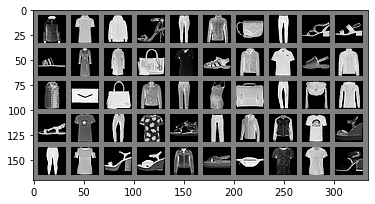

In [80]:
# Load a batch of training images for visualising (with the chosen classes, these should include only t-shirts, trousers, coats, sandals and bags)
data_iterator = iter(trainloader)
images, labels = data_iterator.next()

# Create function for visualisation
def show_image(img):
    img = img * 0.5 + 0.5 # This is to reverse the normalisation done earlier
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
show_image(torchvision.utils.make_grid(images,10,5))
plt.show()

In [81]:
# Define class that constructs the CNN
class Neural_Network(nn.Module):
    # CNN layers
    def __init__(self):
        
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 5)

        self.drop = nn.Dropout2d(0.25)

        self.losses = []
        self.accuracies = []

        self.validlosses = []
        self.validaccuracies = []

        self.epoch_track = []
    
    # Forward pass    
    def forward(self, x, activation, p = True):

        if activation == 'relu':
          x = F.max_pool2d(self.conv1(x), 2)
          x = F.relu(x)
      
          x = F.max_pool2d(self.conv2(x), 2)
          x = F.relu(x)
      
          x = x.view(x.size(0), -1) # The output of the 2nd convolutional layer needs to be flattened to feed into the next layer
  
          x = F.relu(self.fc1(x))
          if p == True:
            x = self.drop(x) 
          x = self.fc2(x)
        
        elif activation == 'tanh':
          x = F.max_pool2d(self.conv1(x), 2)
          x = F.tanh(x)
      
          x = F.max_pool2d(self.conv2(x), 2)
          x = F.tanh(x)
      
          x = x.view(x.size(0), -1) # The output of the 2nd convolutional layer needs to be flattened to feed into the next layer
  
          x = F.tanh(self.fc1(x))
          if p == True:
            x = self.drop(x) 
          x = self.fc2(x)
        
        elif activation == 'sigmoid':
          x = F.max_pool2d(self.conv1(x), 2)
          x = F.sigmoid(x)
      
          x = F.max_pool2d(self.conv2(x), 2)
          x = F.sigmoid(x)
      
          x = x.view(x.size(0), -1) # The output of the 2nd convolutional layer needs to be flattened to feed into the next layer
  
          x = F.sigmoid(self.fc1(x))
          if p == True:
            x = self.drop(x) 
          x = self.fc2(x)

        elif activation == 'leaky_relu':
          x = F.max_pool2d(self.conv1(x), 2)
          x = F.leaky_relu(x)
      
          x = F.max_pool2d(self.conv2(x), 2)
          x = F.leaky_relu(x)
      
          x = x.view(x.size(0), -1) # The output of the 2nd convolutional layer needs to be flattened to feed into the next layer
  
          x = F.leaky_relu(self.fc1(x))
          if p == True:
            x = self.drop(x) 
          x = self.fc2(x)

        
        return x

    # Training and validation
    def train_valid_net(self, trainset, validset, no_epochs, lr, optimizer, activation, momentum = 0, reg_coeff = 0):
        
        loss_func = nn.CrossEntropyLoss() # Define cross entropy loss
        if optimizer == 'SGD':
          optimizer = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
        elif optimizer == 'adam':
          optimizer = optim.Adam(net.parameters(), lr = lr)
        elif optimizer == 'RMSProp':
          optimizer = optim.RMSprop(net.parameters(), lr = lr, momentum = momentum)
          
        epoch = 1

        for epoch in range(no_epochs):

            current_epoch = epoch + 1
            self.epoch_track.append(current_epoch)

            current_loss = 0.0
            current_accuracy = 0.0

            valid_current_loss = 0.0
            valid_current_accuracy = 0.0
            
            # Training
            for batch_index, training_batch in enumerate(trainset, 0):

                l2_loss = 0.0

                inputs, labels = training_batch
                inputs, labels = Variable(inputs), Variable(labels)
                optimizer.zero_grad()
                outputs = self.forward(inputs, activation)
                
                # Calculate loss and optimise
                for param in net.parameters():
                  l2_loss += torch.norm(param)**2
                loss_no_reg = loss_func(outputs, labels)
                loss = loss_no_reg + reg_coeff * l2_loss
                loss.backward()
                optimizer.step()

                current_loss += loss_no_reg.item()
                
                # Calculate accuracy
                correct_pred = 0
                total_pred = 0
                for data in training_batch:
                    images, labels = training_batch
                    outputs = self.forward(Variable(images), activation)
                    dummy, pred_labels = torch.max(outputs.data, 1)
                    correct_pred += (pred_labels == labels).sum().item()
                    total_pred += pred_labels.size(0)
  
                current_accuracy += (100 * correct_pred)/total_pred

                # Show batch loss and accuracy 
                if batch_index % len(trainloader) == (len(trainloader) - 1):
                    print('[Epoch: %d Images in batch: %5d] loss: %.3f' % 
                          (epoch + 1, batch_index+1, current_loss / len(trainloader))) 
                    self.losses.append(current_loss / len(trainloader))
                    self.accuracies.append(current_accuracy / len(trainloader))
                    current_loss = 0.0
                    current_accuracy = 0.0

            # Validation
            for batch_index, validation_batch in enumerate(validset, 0):
                valid_inputs, valid_labels = validation_batch
                valid_inputs, valid_labels = Variable(valid_inputs), Variable(valid_labels)
                valid_outputs = self.forward(valid_inputs, activation)
                
                # Calculate loss
                valid_loss = loss_func(valid_outputs, valid_labels)
                valid_current_loss += valid_loss.item()
                
                # Calculate accuracy
                valid_correct_pred = 0
                valid_total_pred = 0
                for data in validation_batch:
                    valid_images, valid_labels = validation_batch
                    valid_outputs = self.forward(Variable(valid_images), activation)
                    valid_dummy, valid_pred_labels = torch.max(valid_outputs.data, 1)
                    valid_correct_pred += (valid_pred_labels == valid_labels).sum().item()
                    valid_total_pred += valid_pred_labels.size(0)
  
                valid_current_accuracy += (100 * valid_correct_pred)/valid_total_pred

                # Show batch loss and accuracy 
                if batch_index % len(validloader) == (len(validloader) - 1):
                    print('[Epoch: %d Images in batch: %5d] loss: %.3f' % 
                          (epoch + 1, batch_index+1, valid_current_loss / len(validloader)))
                    self.validlosses.append(valid_current_loss / len(validloader))
                    self.validaccuracies.append(valid_current_accuracy / len(validloader))
                    valid_current_loss = 0.0
                    valid_current_accuracy = 0.0

        print('End of training')

In [82]:
# Create directory to save images
def create_directory():
    image_dir = 'Saved_Train_Accuracy_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

# First Test:
- Optimizer = adam
- Activation = tanh
- Epochs = 50
- Learning rate = 0.01
- Drop out = 0.25
- Regularisation = 0.0002

In [83]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'adam'
activation = 'tanh'
no_epochs = 50
lr = 0.01
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, reg_coeff = reg)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[Epoch: 1 Images in batch:   500] loss: 0.163
[Epoch: 1 Images in batch:   100] loss: 0.167
[Epoch: 2 Images in batch:   500] loss: 0.126
[Epoch: 2 Images in batch:   100] loss: 0.118
[Epoch: 3 Images in batch:   500] loss: 0.126
[Epoch: 3 Images in batch:   100] loss: 0.155
[Epoch: 4 Images in batch:   500] loss: 0.117
[Epoch: 4 Images in batch:   100] loss: 0.117
[Epoch: 5 Images in batch:   500] loss: 0.117
[Epoch: 5 Images in batch:   100] loss: 0.113
[Epoch: 6 Images in batch:   500] loss: 0.113
[Epoch: 6 Images in batch:   100] loss: 0.111
[Epoch: 7 Images in batch:   500] loss: 0.104
[Epoch: 7 Images in batch:   100] loss: 0.120
[Epoch: 8 Images in batch:   500] loss: 0.115
[Epoch: 8 Images in batch:   100] loss: 0.111
[Epoch: 9 Images in batch:   500] loss: 0.102
[Epoch: 9 Images in batch:   100] loss: 0.146
[Epoch: 10 Images in batch:   500] loss: 0.104
[Epoch: 10 Images in batch:   100] loss: 0.136
[Epoch: 11 Images in batch:   500] loss: 0.109
[Epoch: 11 Images in batch:   1

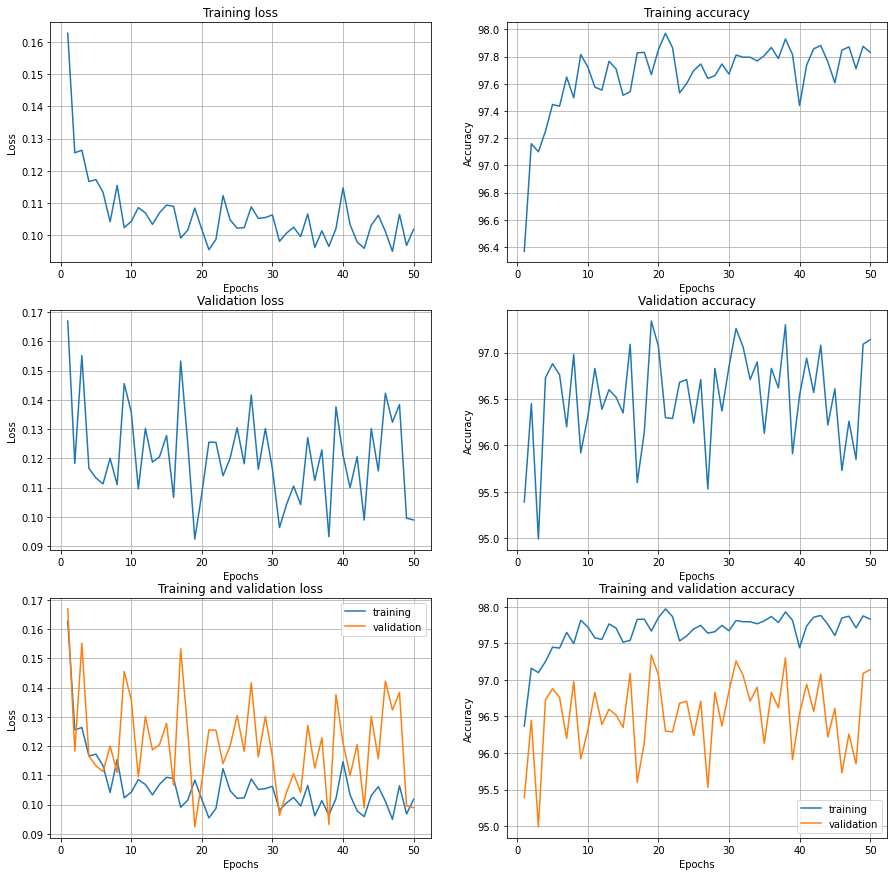

In [84]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [85]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

Maximum accuracy of the network for the training images 97.972000 % at epoch 21
Maximum accuracy of the network for the validation images 97.340000 % at epoch 19


In [86]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy of the network for the training images: 97.56 %


In [97]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)
    
# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [98]:
# Convert confustion matrix to nd array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the validation images: 97.52 %
Per class accuracy tensor([0.9561, 0.9795, 0.9833, 0.9970, 0.9594])


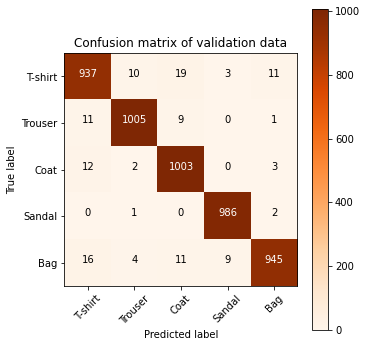

In [99]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [102]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [103]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the test images: 97.52 %
Loss : 0.078
Per class accuracy tensor([0.9470, 0.9890, 0.9860, 0.9990, 0.9550])


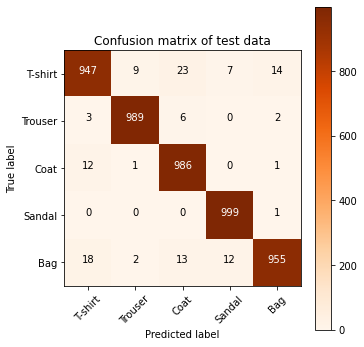

In [104]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [105]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy of class 0 : 95.74 %
Accuracy of class 1 : 100.00 %
Accuracy of class 2 : 99.00 %
Accuracy of class 3 : 100.00 %
Accuracy of class 4 : 97.89 %


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


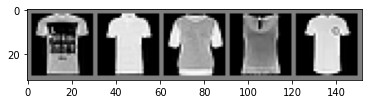

  Correct Label:      0     0     0     0     0
Predicted Label:      0     0     0     0     0


In [106]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))

# Second Test:
- Optimizer = Adam
- Activation = Leaky ReLU
- Epochs = 50
- Learning rate = 0.01
- Drop out = 0.25
- Regularisation = 0.0002

In [107]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'adam'
activation = 'leaky_relu'
no_epochs = 50
lr = 0.01
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, reg_coeff = reg)

[Epoch: 1 Images in batch:   500] loss: 0.177
[Epoch: 1 Images in batch:   100] loss: 0.116
[Epoch: 2 Images in batch:   500] loss: 0.108
[Epoch: 2 Images in batch:   100] loss: 0.099
[Epoch: 3 Images in batch:   500] loss: 0.095
[Epoch: 3 Images in batch:   100] loss: 0.091
[Epoch: 4 Images in batch:   500] loss: 0.088
[Epoch: 4 Images in batch:   100] loss: 0.090
[Epoch: 5 Images in batch:   500] loss: 0.098
[Epoch: 5 Images in batch:   100] loss: 0.233
[Epoch: 6 Images in batch:   500] loss: 0.088
[Epoch: 6 Images in batch:   100] loss: 0.094
[Epoch: 7 Images in batch:   500] loss: 0.078
[Epoch: 7 Images in batch:   100] loss: 0.101
[Epoch: 8 Images in batch:   500] loss: 0.081
[Epoch: 8 Images in batch:   100] loss: 0.084
[Epoch: 9 Images in batch:   500] loss: 0.077
[Epoch: 9 Images in batch:   100] loss: 0.117
[Epoch: 10 Images in batch:   500] loss: 0.078
[Epoch: 10 Images in batch:   100] loss: 0.091
[Epoch: 11 Images in batch:   500] loss: 0.074
[Epoch: 11 Images in batch:   1

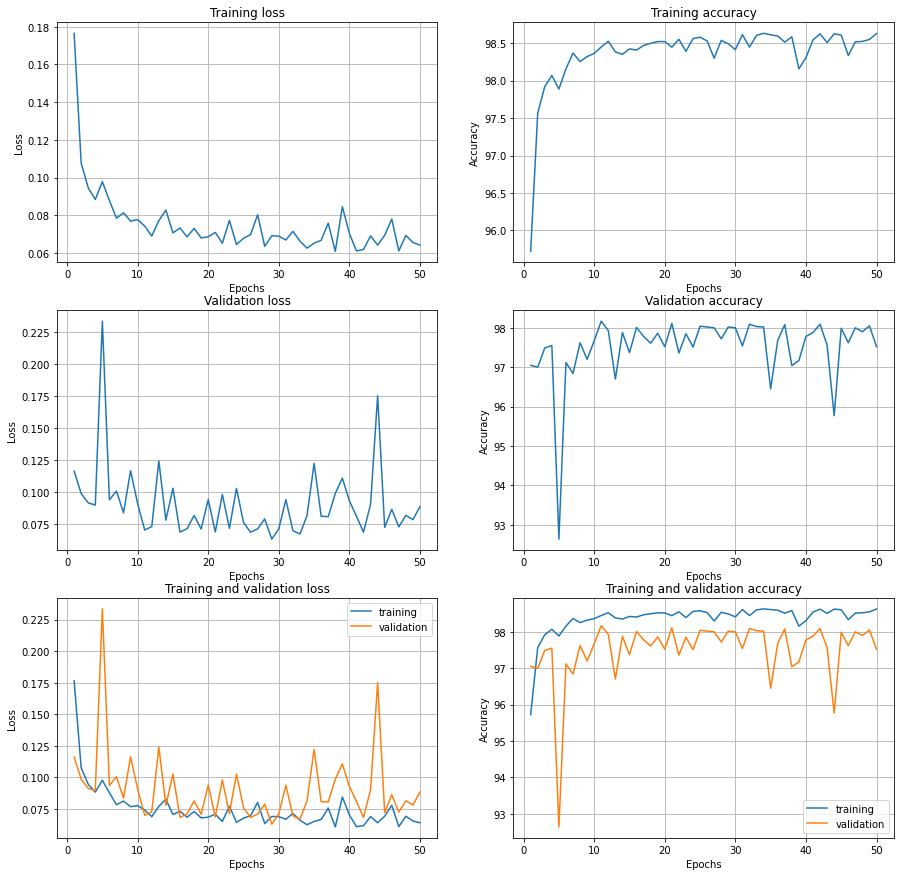

In [108]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [109]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

Maximum accuracy of the network for the training images 98.630000 % at epoch 34
Maximum accuracy of the network for the validation images 98.170000 % at epoch 11


In [110]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

Accuracy of the network for the training images: 97.84 %


In [112]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)

# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

In [113]:
# Convert confustion matrix to numpy array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the validation images: 97.40 %
Per class accuracy tensor([0.9796, 0.9825, 0.9725, 0.9970, 0.9381])


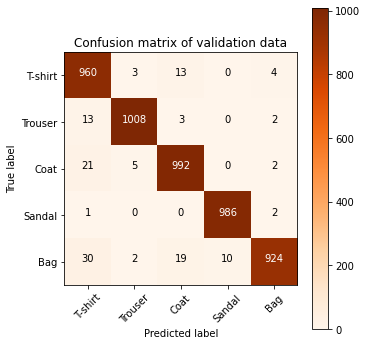

In [114]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [115]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

In [116]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the test images: 97.52 %
Loss : 0.093
Per class accuracy tensor([0.9730, 0.9830, 0.9770, 0.9990, 0.9440])


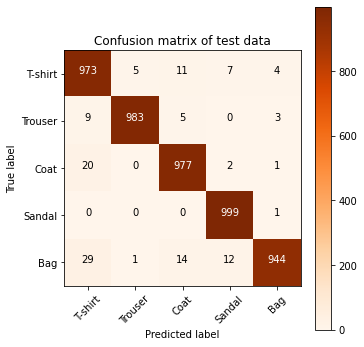

In [117]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [118]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

Accuracy of class 0 : 97.20 %
Accuracy of class 1 : 100.00 %
Accuracy of class 2 : 96.00 %
Accuracy of class 3 : 100.00 %
Accuracy of class 4 : 91.67 %


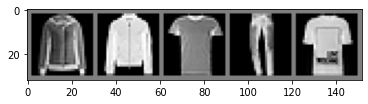

  Correct Label:      2     2     0     1     0
Predicted Label:      2     2     0     1     0


In [119]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))

# Third Test:
- Optimizer = Adam
- Activation = ReLU
- Epochs = 50
- Learning rate = 0.01
- Drop out = 0.25
- Regularisation = 0.0002

In [ ]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'adam'
activation = 'relu'
no_epochs = 50
lr = 0.01
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, reg_coeff = reg)

In [ ]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [ ]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

In [ ]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

In [ ]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)

# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [ ]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [ ]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

In [ ]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))

# Fourth Test:
- Optimizer = Adam
- Activation = Leaky ReLU
- Epochs = 50
- Learning rate = 0.001
- Drop out = 0.25
- Regularisation = 0.0002

In [ ]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'adam'
activation = 'leaky_relu'
no_epochs = 50
lr = 0.001
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, reg_coeff = reg)

[Epoch: 1 Images in batch:   500] loss: 0.245
[Epoch: 1 Images in batch:   100] loss: 0.120
[Epoch: 2 Images in batch:   500] loss: 0.100
[Epoch: 2 Images in batch:   100] loss: 0.110
[Epoch: 3 Images in batch:   500] loss: 0.081
[Epoch: 3 Images in batch:   100] loss: 0.077
[Epoch: 4 Images in batch:   500] loss: 0.069
[Epoch: 4 Images in batch:   100] loss: 0.066
[Epoch: 5 Images in batch:   500] loss: 0.062
[Epoch: 5 Images in batch:   100] loss: 0.065
[Epoch: 6 Images in batch:   500] loss: 0.054
[Epoch: 6 Images in batch:   100] loss: 0.068
[Epoch: 7 Images in batch:   500] loss: 0.049
[Epoch: 7 Images in batch:   100] loss: 0.055
[Epoch: 8 Images in batch:   500] loss: 0.044
[Epoch: 8 Images in batch:   100] loss: 0.056
[Epoch: 9 Images in batch:   500] loss: 0.041
[Epoch: 9 Images in batch:   100] loss: 0.050
[Epoch: 10 Images in batch:   500] loss: 0.038
[Epoch: 10 Images in batch:   100] loss: 0.049
[Epoch: 11 Images in batch:   500] loss: 0.034
[Epoch: 11 Images in batch:   1

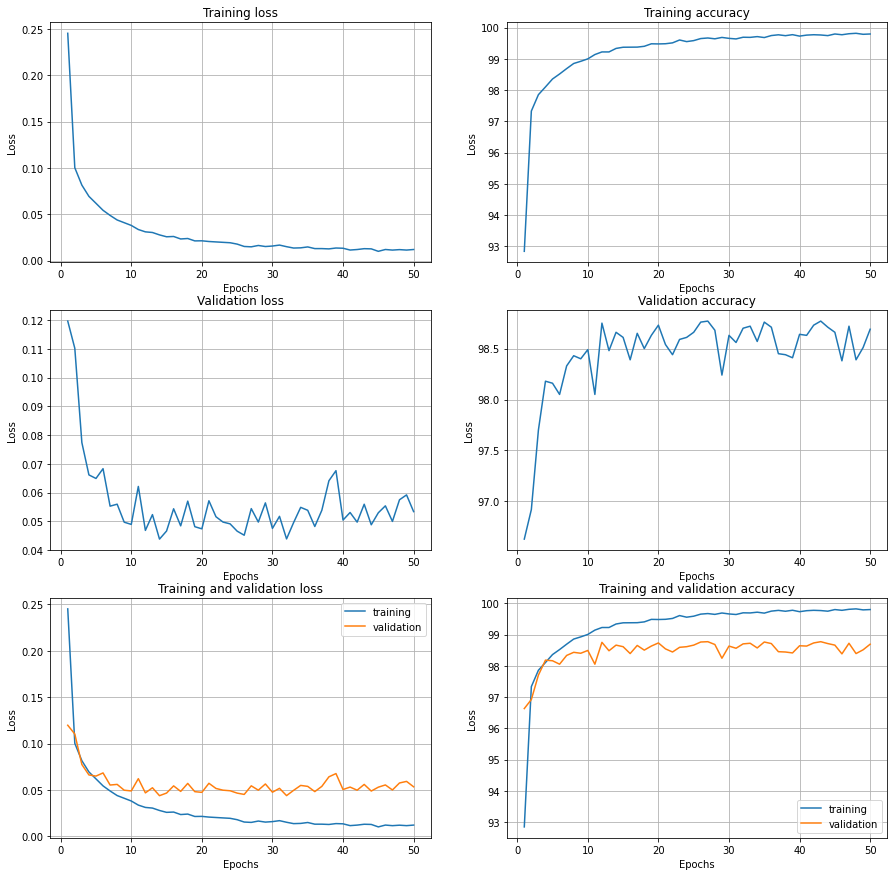

In [ ]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [ ]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

Maximum accuracy of the network for the training images 99.820000 % at epoch 48
Maximum accuracy of the network for the validation images 98.770000 % at epoch 27


In [ ]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

Accuracy of the network for the training images: 99.80 %


In [ ]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)

# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the validation images: 98.70 %
Per class accuracy tensor([0.9848, 0.9875, 0.9804, 0.9971, 0.9846])


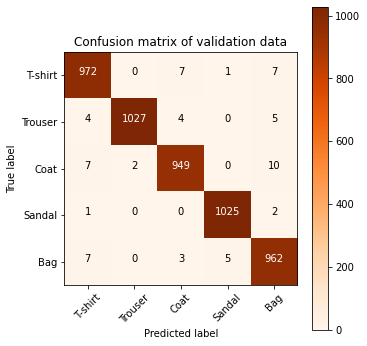

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [ ]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the test images: 98.74 %
Loss : 0.058
Per class accuracy tensor([0.9790, 0.9860, 0.9920, 0.9980, 0.9820])


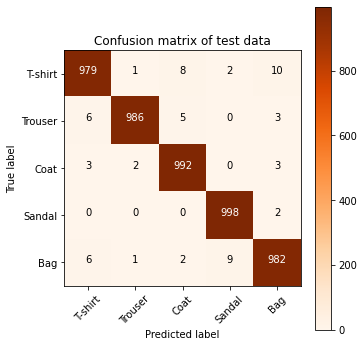

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [ ]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

Accuracy of class 0 : 95.88 %
Accuracy of class 1 : 98.95 %
Accuracy of class 2 : 99.04 %
Accuracy of class 3 : 100.00 %
Accuracy of class 4 : 96.36 %


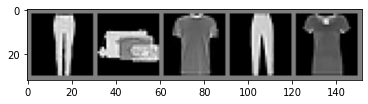

  Correct Label:      1     4     0     1     0
Predicted Label:      1     4     0     1     0


In [ ]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))

# Fifth Test:
- Optimizer = SGD w/o momentum
- Activation = Leaky ReLU
- Epochs = 50
- Learning rate = 0.001
- Drop out = 0.25
- Regularisation = 0.0002

In [ ]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'SGD'
activation = 'leaky_relu'
no_epochs = 50
lr = 0.001
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, reg_coeff = reg)

[Epoch: 1 Images in batch:   500] loss: 1.602
[Epoch: 1 Images in batch:   100] loss: 1.590
[Epoch: 2 Images in batch:   500] loss: 1.573
[Epoch: 2 Images in batch:   100] loss: 1.550
[Epoch: 3 Images in batch:   500] loss: 1.516
[Epoch: 3 Images in batch:   100] loss: 1.468
[Epoch: 4 Images in batch:   500] loss: 1.375
[Epoch: 4 Images in batch:   100] loss: 1.249
[Epoch: 5 Images in batch:   500] loss: 1.099
[Epoch: 5 Images in batch:   100] loss: 0.969
[Epoch: 6 Images in batch:   500] loss: 0.862
[Epoch: 6 Images in batch:   100] loss: 0.787
[Epoch: 7 Images in batch:   500] loss: 0.718
[Epoch: 7 Images in batch:   100] loss: 0.659
[Epoch: 8 Images in batch:   500] loss: 0.606
[Epoch: 8 Images in batch:   100] loss: 0.563
[Epoch: 9 Images in batch:   500] loss: 0.529
[Epoch: 9 Images in batch:   100] loss: 0.491
[Epoch: 10 Images in batch:   500] loss: 0.465
[Epoch: 10 Images in batch:   100] loss: 0.438
[Epoch: 11 Images in batch:   500] loss: 0.410
[Epoch: 11 Images in batch:   1

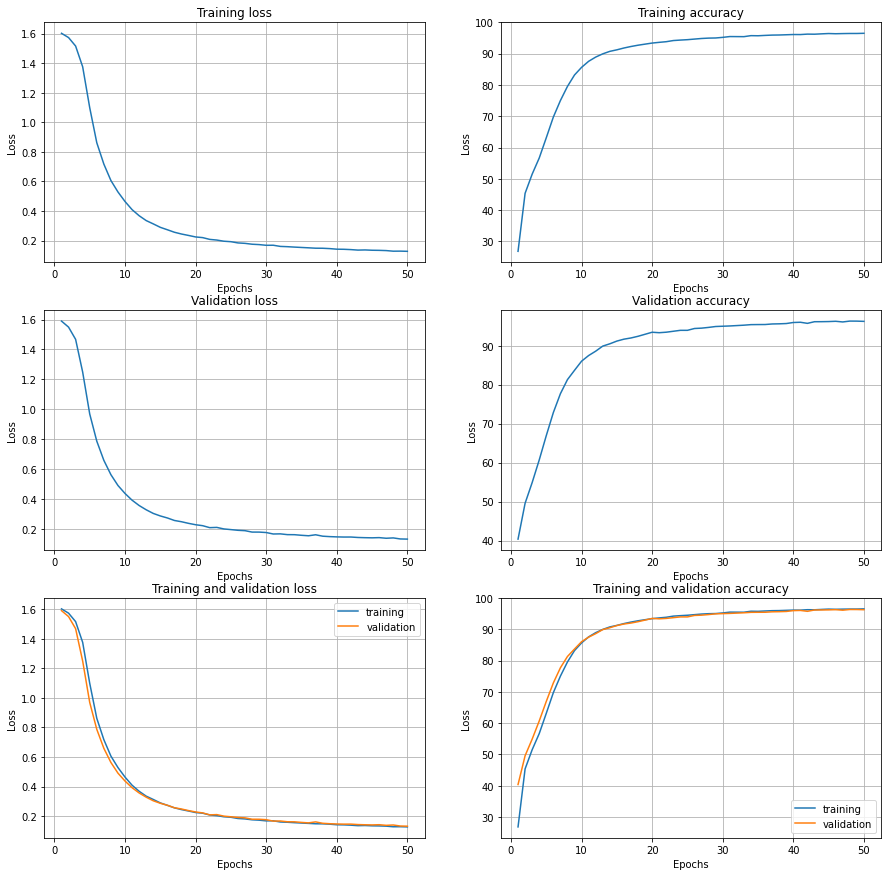

In [ ]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [ ]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

Maximum accuracy of the network for the training images 96.518000 % at epoch 50
Maximum accuracy of the network for the validation images 96.320000 % at epoch 48


In [ ]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

Accuracy of the network for the training images: 96.53 %


In [ ]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)

# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the validation images: 96.34 %
Per class accuracy tensor([0.9357, 0.9659, 0.9676, 0.9909, 0.9563])


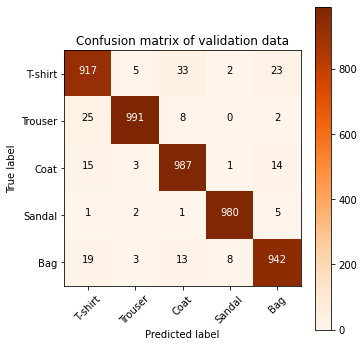

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [ ]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the test images: 96.22 %
Loss : 0.144
Per class accuracy tensor([0.9350, 0.9660, 0.9710, 0.9860, 0.9530])


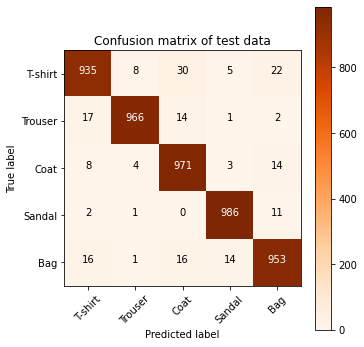

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [ ]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

Accuracy of class 0 : 93.26 %
Accuracy of class 1 : 97.89 %
Accuracy of class 2 : 99.13 %
Accuracy of class 3 : 98.99 %
Accuracy of class 4 : 92.16 %


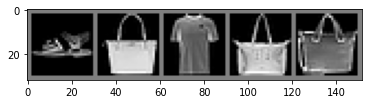

  Correct Label:      3     4     0     4     4
Predicted Label:      3     4     0     4     4


In [ ]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))

# Sixth Test:
- Optimizer = SGD w/ momentum
- Activation = Leaky ReLU
- Epochs = 50
- Learning rate = 0.001
- Momentum = 0.9
- Drop out = 0.25
- Regularisation = 0.0002

In [ ]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'SGD'
activation = 'leaky_relu'
no_epochs = 50
lr = 0.001
mom = 0.9
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, momentum = mom, reg_coeff = reg)

[Epoch: 1 Images in batch:   500] loss: 0.786
[Epoch: 1 Images in batch:   100] loss: 0.290
[Epoch: 2 Images in batch:   500] loss: 0.217
[Epoch: 2 Images in batch:   100] loss: 0.185
[Epoch: 3 Images in batch:   500] loss: 0.163
[Epoch: 3 Images in batch:   100] loss: 0.155
[Epoch: 4 Images in batch:   500] loss: 0.139
[Epoch: 4 Images in batch:   100] loss: 0.130
[Epoch: 5 Images in batch:   500] loss: 0.125
[Epoch: 5 Images in batch:   100] loss: 0.128
[Epoch: 6 Images in batch:   500] loss: 0.115
[Epoch: 6 Images in batch:   100] loss: 0.115
[Epoch: 7 Images in batch:   500] loss: 0.108
[Epoch: 7 Images in batch:   100] loss: 0.107
[Epoch: 8 Images in batch:   500] loss: 0.101
[Epoch: 8 Images in batch:   100] loss: 0.101
[Epoch: 9 Images in batch:   500] loss: 0.096
[Epoch: 9 Images in batch:   100] loss: 0.097
[Epoch: 10 Images in batch:   500] loss: 0.091
[Epoch: 10 Images in batch:   100] loss: 0.099
[Epoch: 11 Images in batch:   500] loss: 0.088
[Epoch: 11 Images in batch:   1

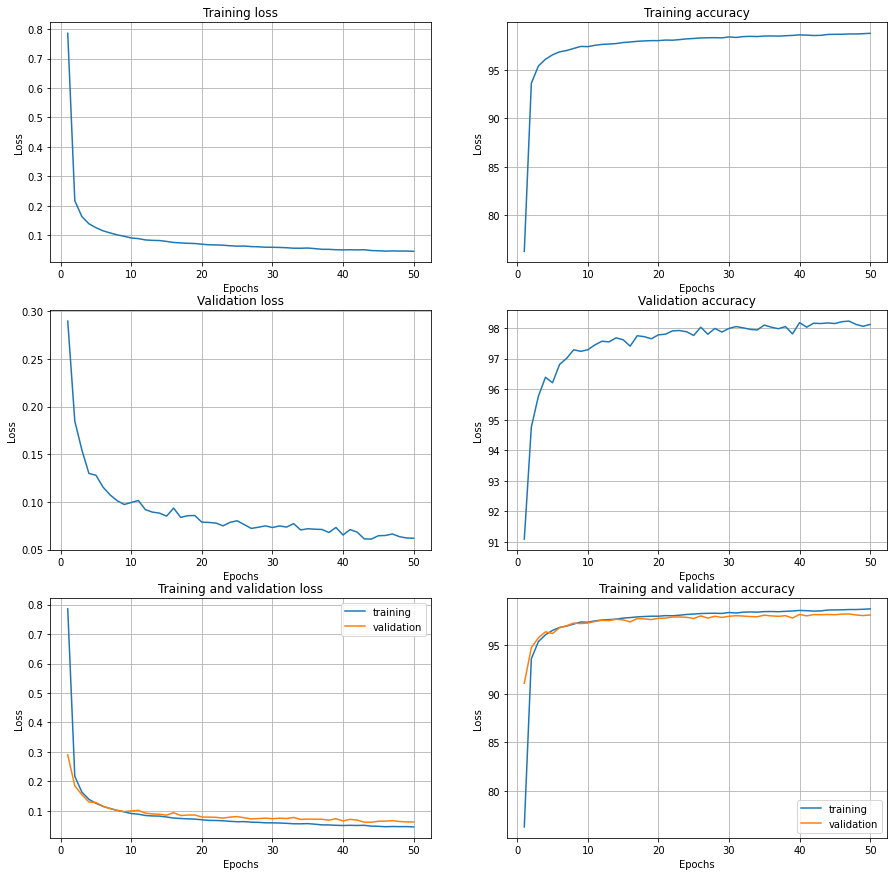

In [ ]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [ ]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

Maximum accuracy of the network for the training images 98.750000 % at epoch 50
Maximum accuracy of the network for the validation images 98.230000 % at epoch 47


In [ ]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

Accuracy of the network for the training images: 98.70 %


In [ ]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)

# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the validation images: 98.20 %
Per class accuracy tensor([0.9582, 0.9854, 0.9814, 0.9980, 0.9868])


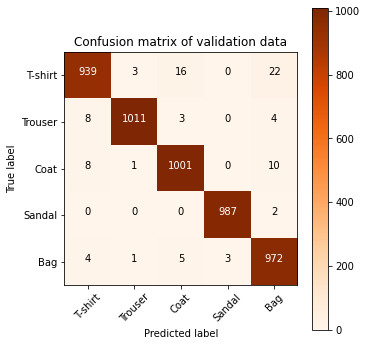

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [ ]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the test images: 98.22 %
Loss : 0.067
Per class accuracy tensor([0.9540, 0.9870, 0.9830, 0.9980, 0.9890])


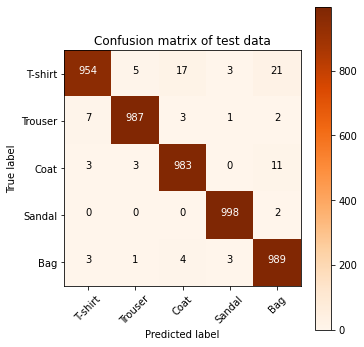

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [ ]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

Accuracy of class 0 : 95.70 %
Accuracy of class 1 : 98.35 %
Accuracy of class 2 : 100.00 %
Accuracy of class 3 : 100.00 %
Accuracy of class 4 : 98.97 %


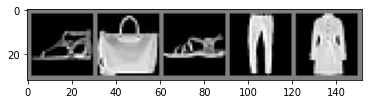

  Correct Label:      3     4     3     1     2
Predicted Label:      3     4     3     1     2


In [ ]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))

# Seventh Test:
- Optimizer = RMSProp w/o momentum
- Activation = Leaky ReLU
- Epochs = 50
- Learning rate = 0.001
- Momentum = 0.9
- Drop out = 0.25
- Regularisation = 0.0002

In [ ]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'RMSProp'
activation = 'leaky_relu'
no_epochs = 50
lr = 0.001
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, reg_coeff = reg)

[Epoch: 1 Images in batch:   500] loss: 0.170
[Epoch: 1 Images in batch:   100] loss: 0.099
[Epoch: 2 Images in batch:   500] loss: 0.084
[Epoch: 2 Images in batch:   100] loss: 0.093
[Epoch: 3 Images in batch:   500] loss: 0.068
[Epoch: 3 Images in batch:   100] loss: 0.074
[Epoch: 4 Images in batch:   500] loss: 0.060
[Epoch: 4 Images in batch:   100] loss: 0.063
[Epoch: 5 Images in batch:   500] loss: 0.051
[Epoch: 5 Images in batch:   100] loss: 0.061
[Epoch: 6 Images in batch:   500] loss: 0.047
[Epoch: 6 Images in batch:   100] loss: 0.059
[Epoch: 7 Images in batch:   500] loss: 0.042
[Epoch: 7 Images in batch:   100] loss: 0.060
[Epoch: 8 Images in batch:   500] loss: 0.040
[Epoch: 8 Images in batch:   100] loss: 0.061
[Epoch: 9 Images in batch:   500] loss: 0.037
[Epoch: 9 Images in batch:   100] loss: 0.063
[Epoch: 10 Images in batch:   500] loss: 0.035
[Epoch: 10 Images in batch:   100] loss: 0.058
[Epoch: 11 Images in batch:   500] loss: 0.032
[Epoch: 11 Images in batch:   1

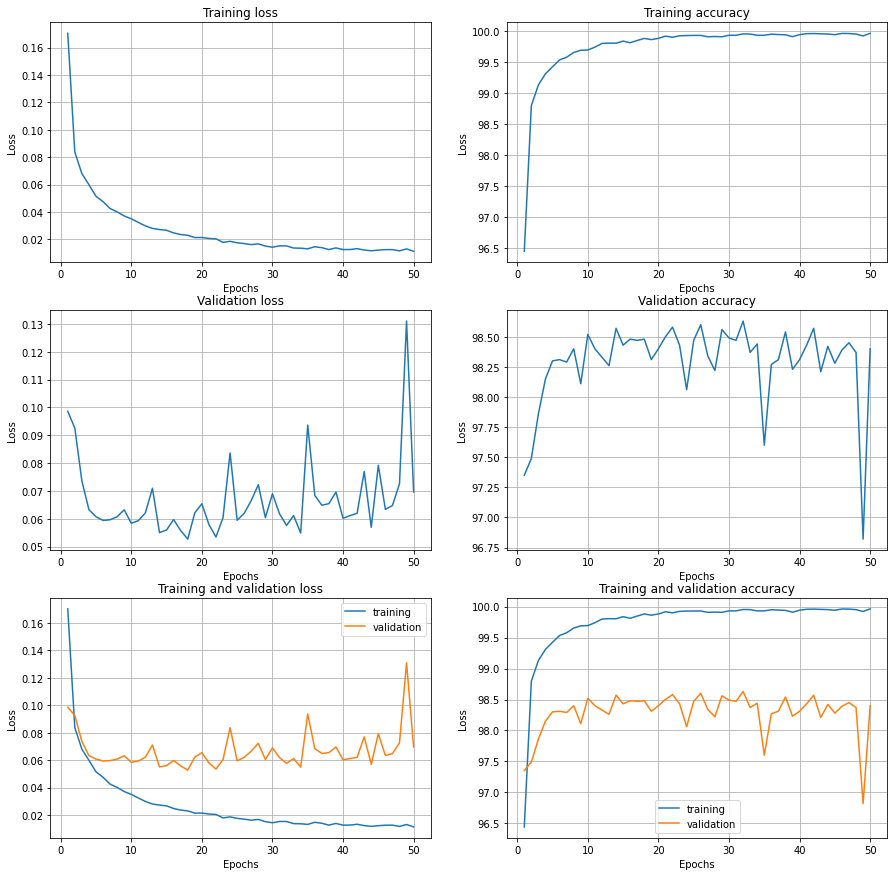

In [ ]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [ ]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

Maximum accuracy of the network for the training images 99.964000 % at epoch 50
Maximum accuracy of the network for the validation images 98.630000 % at epoch 32


In [ ]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

Accuracy of the network for the training images: 99.80 %


In [ ]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)

# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the validation images: 98.52 %
Per class accuracy tensor([0.9765, 0.9795, 0.9863, 0.9970, 0.9868])


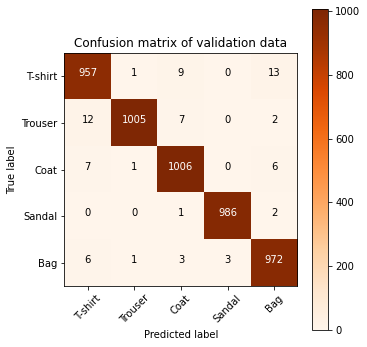

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [ ]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the test images: 98.46 %
Loss : 0.065
Per class accuracy tensor([0.9660, 0.9820, 0.9920, 1.0000, 0.9830])


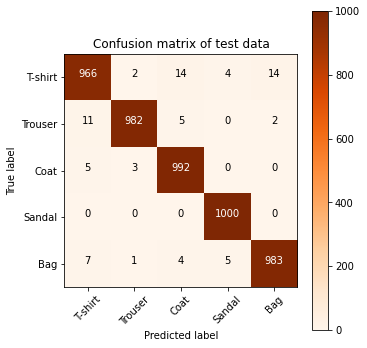

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [ ]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

Accuracy of class 0 : 99.02 %
Accuracy of class 1 : 98.10 %
Accuracy of class 2 : 98.00 %
Accuracy of class 3 : 100.00 %
Accuracy of class 4 : 98.94 %


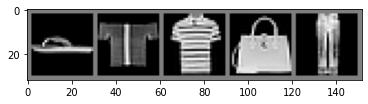

  Correct Label:      3     0     0     4     1
Predicted Label:      3     4     0     4     1


In [ ]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))

# Eighth Test:
- Optimizer = RMSProp w/ momentum
- Activation = tanh
- Epochs = 50
- Learning rate = 0.001
- Momentum = 0.9
- Drop out = 0.25
- Regularisation = 0.0002

In [ ]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'RMSProp'
activation = 'leaky_relu'
no_epochs = 50
lr = 0.001
momentum = 0.9
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, momentum, reg_coeff = reg)

[Epoch: 1 Images in batch:   500] loss: 0.199
[Epoch: 1 Images in batch:   100] loss: 0.138
[Epoch: 2 Images in batch:   500] loss: 0.111
[Epoch: 2 Images in batch:   100] loss: 0.112
[Epoch: 3 Images in batch:   500] loss: 0.101
[Epoch: 3 Images in batch:   100] loss: 0.133
[Epoch: 4 Images in batch:   500] loss: 0.089
[Epoch: 4 Images in batch:   100] loss: 0.102
[Epoch: 5 Images in batch:   500] loss: 0.090
[Epoch: 5 Images in batch:   100] loss: 0.095
[Epoch: 6 Images in batch:   500] loss: 0.085
[Epoch: 6 Images in batch:   100] loss: 0.079
[Epoch: 7 Images in batch:   500] loss: 0.088
[Epoch: 7 Images in batch:   100] loss: 0.109
[Epoch: 8 Images in batch:   500] loss: 0.081
[Epoch: 8 Images in batch:   100] loss: 0.097
[Epoch: 9 Images in batch:   500] loss: 0.086
[Epoch: 9 Images in batch:   100] loss: 0.124
[Epoch: 10 Images in batch:   500] loss: 0.078
[Epoch: 10 Images in batch:   100] loss: 0.078
[Epoch: 11 Images in batch:   500] loss: 0.076
[Epoch: 11 Images in batch:   1

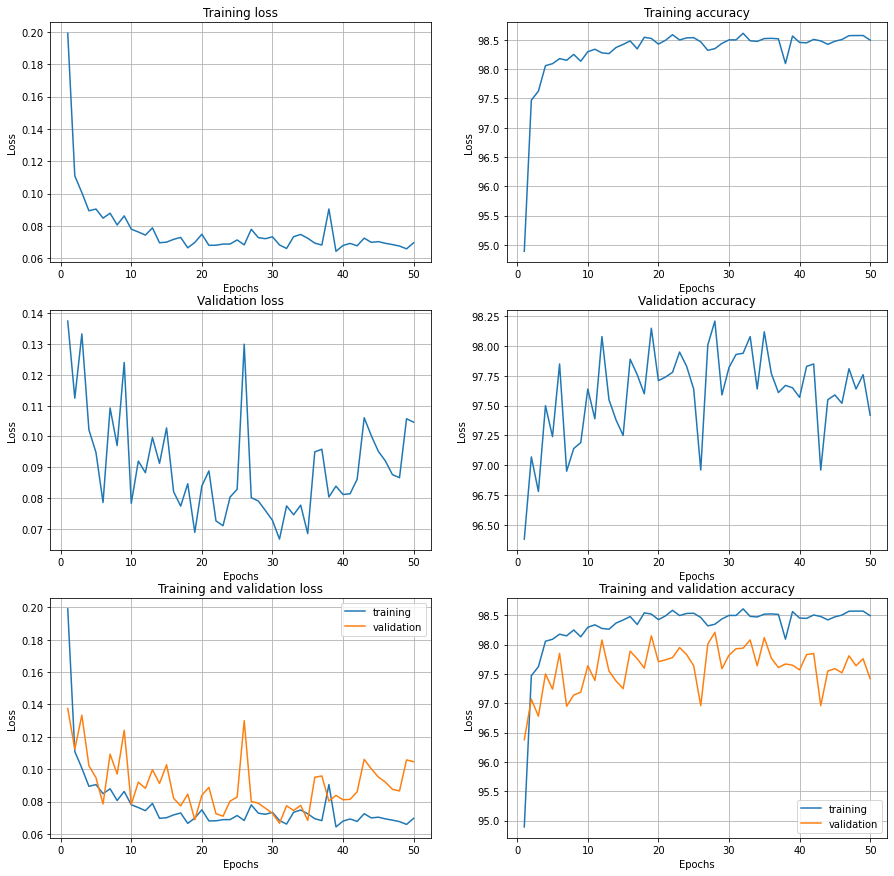

In [ ]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [ ]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

Maximum accuracy of the network for the training images 98.610000 % at epoch 32
Maximum accuracy of the network for the validation images 98.210000 % at epoch 28


In [ ]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

Accuracy of the network for the training images: 97.89 %


In [ ]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)

# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the validation images: 97.36 %
Per class accuracy tensor([0.9673, 0.9776, 0.9588, 0.9818, 0.9827])


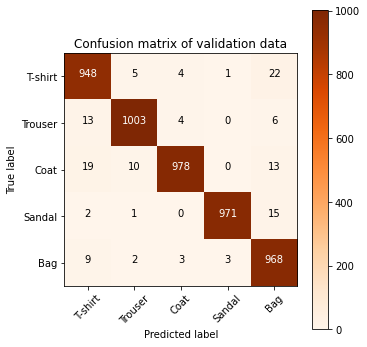

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [ ]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the test images: 97.38 %
Loss : 0.092
Per class accuracy tensor([0.9630, 0.9840, 0.9670, 0.9750, 0.9800])


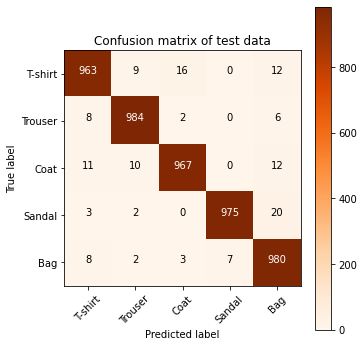

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [ ]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

Accuracy of class 0 : 93.00 %
Accuracy of class 1 : 97.46 %
Accuracy of class 2 : 97.67 %
Accuracy of class 3 : 97.03 %
Accuracy of class 4 : 97.89 %


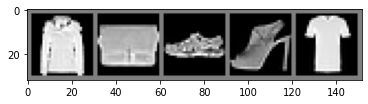

  Correct Label:      2     4     3     3     0
Predicted Label:      2     4     3     3     0


In [ ]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))

# Nineth Test:
- Optimizer = Adam
- Activation = tanh
- Epochs = 50
- Learning rate = 0.001
- Drop out = 0.25
- Regularisation = 0.0002

In [ ]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'adam'
activation = 'tanh'
no_epochs = 50
lr = 0.001
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, reg_coeff = reg)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[Epoch: 1 Images in batch:   500] loss: 0.212
[Epoch: 1 Images in batch:   100] loss: 0.098
[Epoch: 2 Images in batch:   500] loss: 0.085
[Epoch: 2 Images in batch:   100] loss: 0.076
[Epoch: 3 Images in batch:   500] loss: 0.069
[Epoch: 3 Images in batch:   100] loss: 0.071
[Epoch: 4 Images in batch:   500] loss: 0.061
[Epoch: 4 Images in batch:   100] loss: 0.068
[Epoch: 5 Images in batch:   500] loss: 0.056
[Epoch: 5 Images in batch:   100] loss: 0.060
[Epoch: 6 Images in batch:   500] loss: 0.052
[Epoch: 6 Images in batch:   100] loss: 0.065
[Epoch: 7 Images in batch:   500] loss: 0.047
[Epoch: 7 Images in batch:   100] loss: 0.060
[Epoch: 8 Images in batch:   500] loss: 0.040
[Epoch: 8 Images in batch:   100] loss: 0.053
[Epoch: 9 Images in batch:   500] loss: 0.039
[Epoch: 9 Images in batch:   100] loss: 0.056
[Epoch: 10 Images in batch:   500] loss: 0.038
[Epoch: 10 Images in batch:   100] loss: 0.055
[Epoch: 11 Images in batch:   500] loss: 0.034
[Epoch: 11 Images in batch:   1

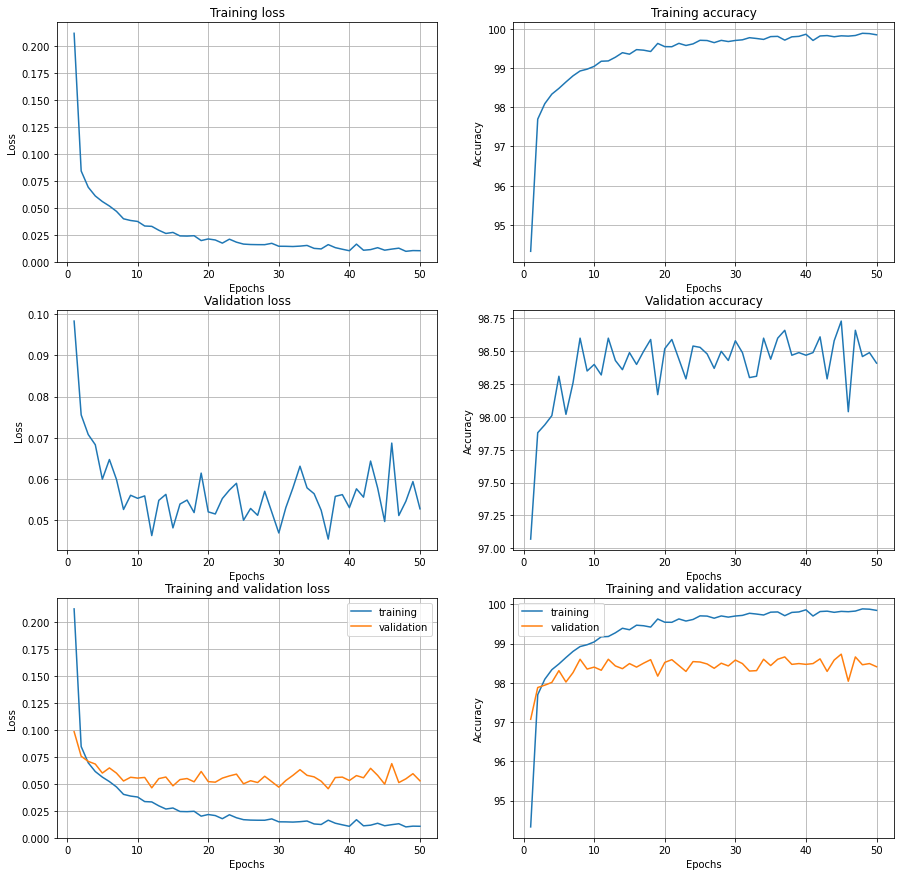

In [ ]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [ ]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

Maximum accuracy of the network for the training images 99.742000 % at epoch 44
Maximum accuracy of the network for the validation images 98.820000 % at epoch 29


In [ ]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

Accuracy of the network for the training images: 99.66 %


In [ ]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)

# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the validation images: 98.70 %
Per class accuracy tensor([0.9848, 0.9894, 0.9793, 0.9942, 0.9867])


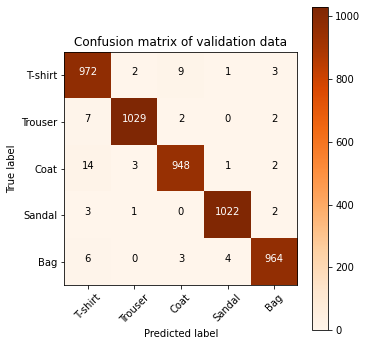

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [ ]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the test images: 98.40 %
Loss : 0.059
Per class accuracy tensor([0.9800, 0.9830, 0.9830, 0.9970, 0.9770])


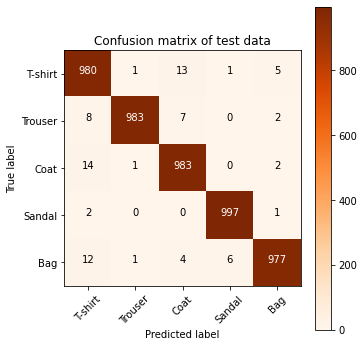

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [ ]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

Accuracy of class 0 : 98.99 %
Accuracy of class 1 : 100.00 %
Accuracy of class 2 : 100.00 %
Accuracy of class 3 : 100.00 %
Accuracy of class 4 : 97.94 %


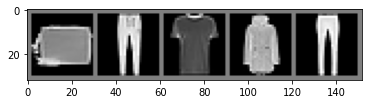

  Correct Label:      4     1     0     2     1
Predicted Label:      4     1     0     2     1


In [ ]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))

# Tenth Test:
- Optimizer = Adam
- Activation = ReLU
- Epochs = 50
- Learning rate = 0.001
- Drop out = 0.25
- Regularisation = 0.0002

In [ ]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'adam'
activation = 'relu'
no_epochs = 50
lr = 0.001
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, reg_coeff = reg)

[Epoch: 1 Images in batch:   500] loss: 0.265
[Epoch: 1 Images in batch:   100] loss: 0.117
[Epoch: 2 Images in batch:   500] loss: 0.107
[Epoch: 2 Images in batch:   100] loss: 0.096
[Epoch: 3 Images in batch:   500] loss: 0.090
[Epoch: 3 Images in batch:   100] loss: 0.083
[Epoch: 4 Images in batch:   500] loss: 0.076
[Epoch: 4 Images in batch:   100] loss: 0.075
[Epoch: 5 Images in batch:   500] loss: 0.068
[Epoch: 5 Images in batch:   100] loss: 0.080
[Epoch: 6 Images in batch:   500] loss: 0.063
[Epoch: 6 Images in batch:   100] loss: 0.063
[Epoch: 7 Images in batch:   500] loss: 0.058
[Epoch: 7 Images in batch:   100] loss: 0.059
[Epoch: 8 Images in batch:   500] loss: 0.052
[Epoch: 8 Images in batch:   100] loss: 0.058
[Epoch: 9 Images in batch:   500] loss: 0.049
[Epoch: 9 Images in batch:   100] loss: 0.062
[Epoch: 10 Images in batch:   500] loss: 0.048
[Epoch: 10 Images in batch:   100] loss: 0.062
[Epoch: 11 Images in batch:   500] loss: 0.043
[Epoch: 11 Images in batch:   1

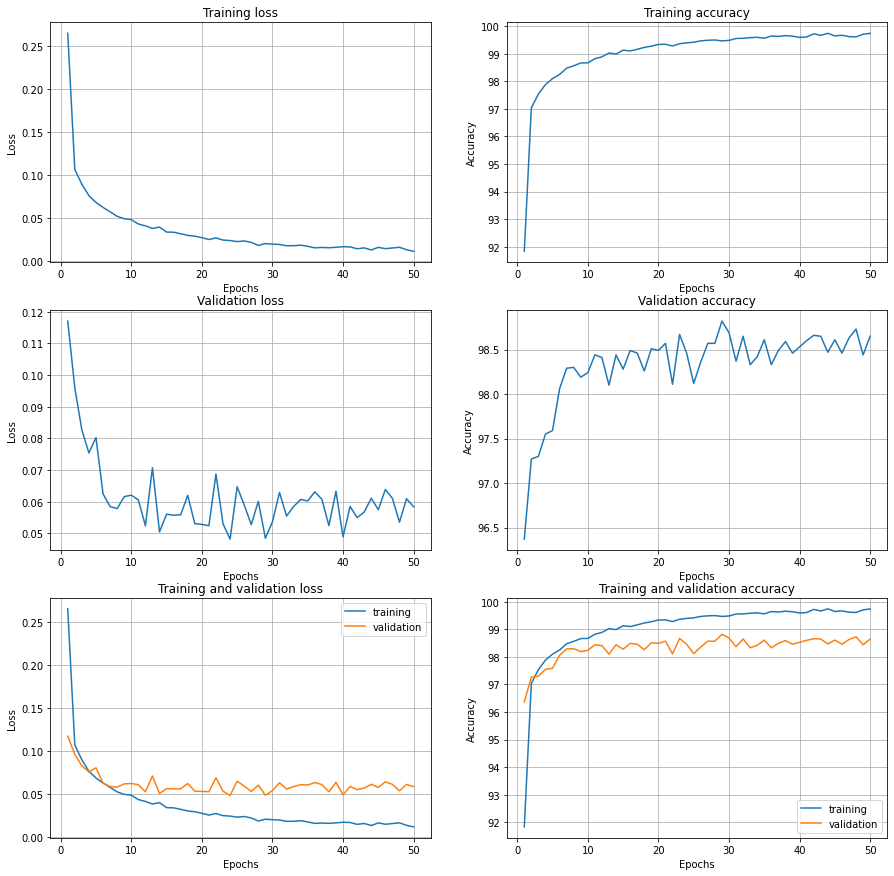

In [ ]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [ ]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

Maximum accuracy of the network for the training images 99.742000 % at epoch 44
Maximum accuracy of the network for the validation images 98.820000 % at epoch 29


In [ ]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

Accuracy of the network for the training images: 99.68 %


In [ ]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)

# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the validation images: 98.56 %
Per class accuracy tensor([0.9848, 0.9904, 0.9762, 0.9951, 0.9806])


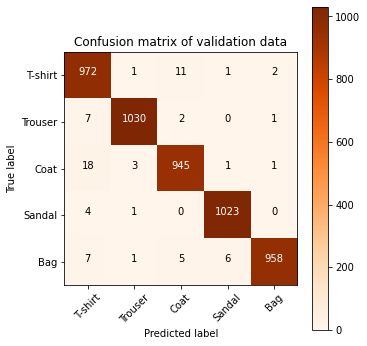

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [ ]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the test images: 98.56 %
Loss : 0.061
Per class accuracy tensor([0.9830, 0.9850, 0.9860, 0.9970, 0.9770])


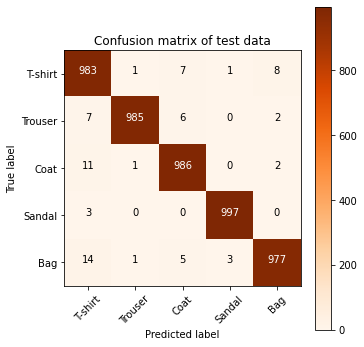

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [ ]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

Accuracy of class 0 : 97.92 %
Accuracy of class 1 : 98.32 %
Accuracy of class 2 : 99.07 %
Accuracy of class 3 : 100.00 %
Accuracy of class 4 : 95.74 %


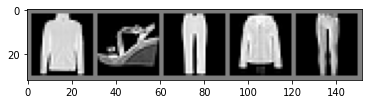

  Correct Label:      2     3     1     2     1
Predicted Label:      2     3     1     2     1


In [ ]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))

# Eleventh Test:
- Optimizer = SGD w/o momentum
- Activation = tanh
- Epochs = 50
- Learning rate = 0.001
- Drop out = 0.25
- Regularisation = 0.0002

In [ ]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'SGD'
activation = 'tanh'
no_epochs = 50
lr = 0.001
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, reg_coeff = reg)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[Epoch: 1 Images in batch:   500] loss: 1.470
[Epoch: 1 Images in batch:   100] loss: 1.303
[Epoch: 2 Images in batch:   500] loss: 1.168
[Epoch: 2 Images in batch:   100] loss: 1.034
[Epoch: 3 Images in batch:   500] loss: 0.955
[Epoch: 3 Images in batch:   100] loss: 0.867
[Epoch: 4 Images in batch:   500] loss: 0.815
[Epoch: 4 Images in batch:   100] loss: 0.749
[Epoch: 5 Images in batch:   500] loss: 0.709
[Epoch: 5 Images in batch:   100] loss: 0.660
[Epoch: 6 Images in batch:   500] loss: 0.624
[Epoch: 6 Images in batch:   100] loss: 0.581
[Epoch: 7 Images in batch:   500] loss: 0.550
[Epoch: 7 Images in batch:   100] loss: 0.514
[Epoch: 8 Images in batch:   500] loss: 0.487
[Epoch: 8 Images in batch:   100] loss: 0.459
[Epoch: 9 Images in batch:   500] loss: 0.435
[Epoch: 9 Images in batch:   100] loss: 0.413
[Epoch: 10 Images in batch:   500] loss: 0.394
[Epoch: 10 Images in batch:   100] loss: 0.377
[Epoch: 11 Images in batch:   500] loss: 0.358
[Epoch: 11 Images in batch:   1

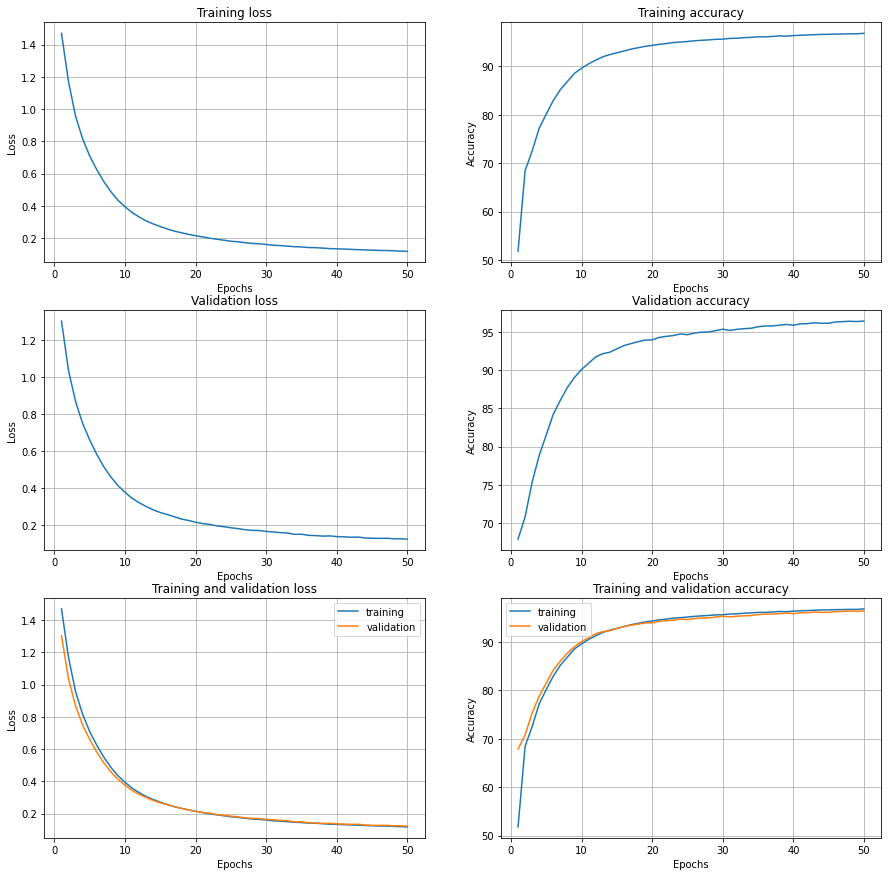

In [ ]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [ ]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

Maximum accuracy of the network for the training images 96.850000 % at epoch 50
Maximum accuracy of the network for the validation images 96.410000 % at epoch 50


In [ ]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy of the network for the training images: 96.75 %


In [ ]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)

# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the validation images: 96.42 %
Per class accuracy tensor([0.9443, 0.9663, 0.9597, 0.9903, 0.9591])


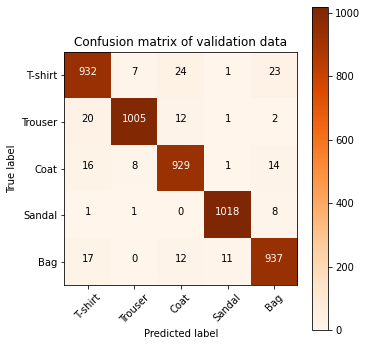

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [ ]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the test images: 96.40 %
Loss : 0.131
Per class accuracy tensor([0.9350, 0.9650, 0.9700, 0.9930, 0.9570])


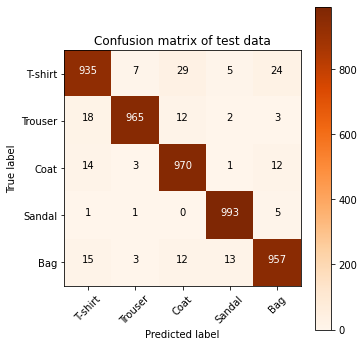

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [ ]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy of class 0 : 96.84 %
Accuracy of class 1 : 96.19 %
Accuracy of class 2 : 99.01 %
Accuracy of class 3 : 97.27 %
Accuracy of class 4 : 97.75 %


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


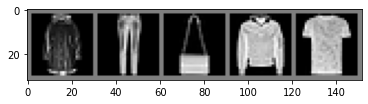

  Correct Label:      2     1     4     2     0
Predicted Label:      2     1     4     2     0


In [ ]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))

# Twelfth Test:
- Optimizer = SGD w/ momentum
- Activation = tanh
- Epochs = 50
- Learning rate = 0.001
- Momentum = 0.9
- Drop out = 0.25
- Regularisation = 0.0002

In [ ]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'SGD'
activation = 'tanh'
no_epochs = 50
mom = 0.9
lr = 0.001
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, momentum = mom, reg_coeff = reg)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[Epoch: 1 Images in batch:   500] loss: 0.775
[Epoch: 1 Images in batch:   100] loss: 0.356
[Epoch: 2 Images in batch:   500] loss: 0.256
[Epoch: 2 Images in batch:   100] loss: 0.199
[Epoch: 3 Images in batch:   500] loss: 0.169
[Epoch: 3 Images in batch:   100] loss: 0.154
[Epoch: 4 Images in batch:   500] loss: 0.138
[Epoch: 4 Images in batch:   100] loss: 0.133
[Epoch: 5 Images in batch:   500] loss: 0.123
[Epoch: 5 Images in batch:   100] loss: 0.121
[Epoch: 6 Images in batch:   500] loss: 0.113
[Epoch: 6 Images in batch:   100] loss: 0.114
[Epoch: 7 Images in batch:   500] loss: 0.106
[Epoch: 7 Images in batch:   100] loss: 0.108
[Epoch: 8 Images in batch:   500] loss: 0.100
[Epoch: 8 Images in batch:   100] loss: 0.101
[Epoch: 9 Images in batch:   500] loss: 0.096
[Epoch: 9 Images in batch:   100] loss: 0.098
[Epoch: 10 Images in batch:   500] loss: 0.093
[Epoch: 10 Images in batch:   100] loss: 0.094
[Epoch: 11 Images in batch:   500] loss: 0.090
[Epoch: 11 Images in batch:   1

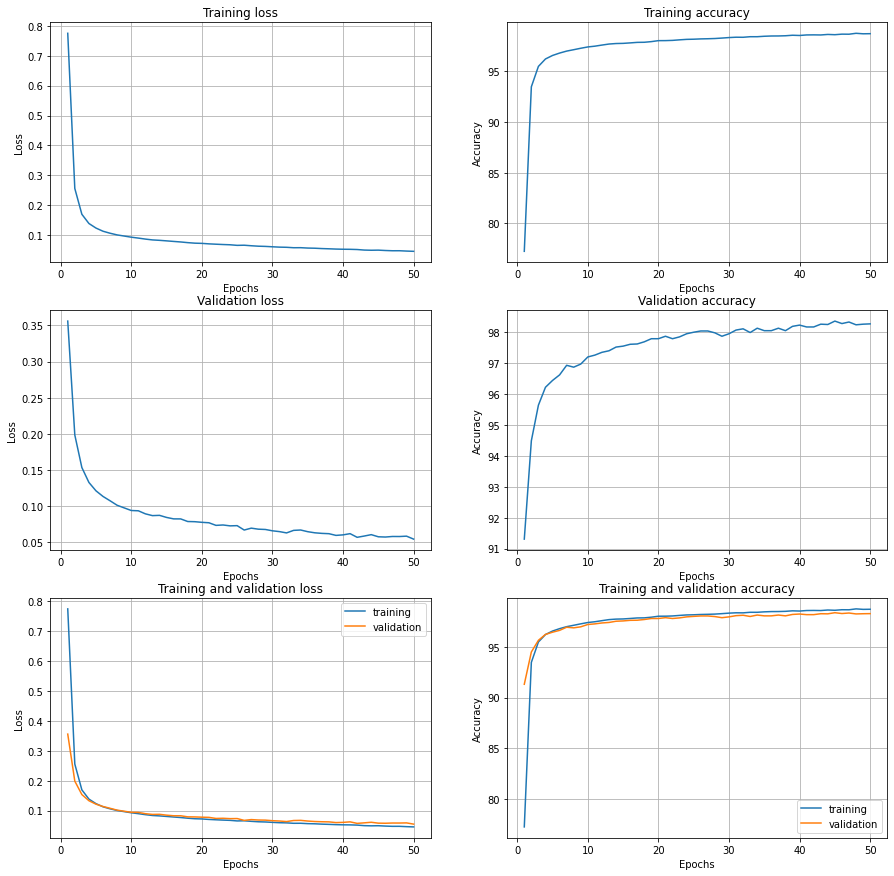

In [ ]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [ ]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

Maximum accuracy of the network for the training images 98.738000 % at epoch 48
Maximum accuracy of the network for the validation images 98.360000 % at epoch 45


In [ ]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy of the network for the training images: 98.72 %


In [ ]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)

# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the validation images: 98.32 %
Per class accuracy tensor([0.9737, 0.9856, 0.9835, 0.9971, 0.9754])


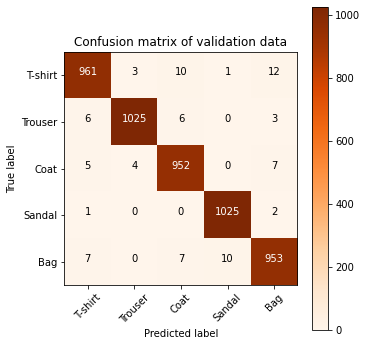

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [ ]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the test images: 98.18 %
Loss : 0.062
Per class accuracy tensor([0.9640, 0.9850, 0.9880, 0.9980, 0.9740])


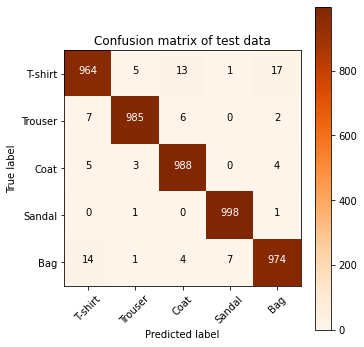

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [ ]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy of class 0 : 98.96 %
Accuracy of class 1 : 99.16 %
Accuracy of class 2 : 100.00 %
Accuracy of class 3 : 100.00 %
Accuracy of class 4 : 93.62 %


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


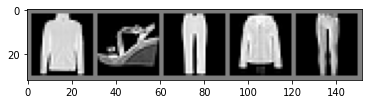

  Correct Label:      2     3     1     2     1
Predicted Label:      2     3     1     2     1


In [ ]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))

# Thirteenth Test:
- Optimizer = RMSProp w/o momentum
- Activation = tanh
- Epochs = 50
- Learning rate = 0.001
- Drop out = 0.25
- Regularisation = 0.0002

In [ ]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'RMSProp'
activation = 'tanh'
no_epochs = 50
lr = 0.001
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, reg_coeff = reg)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[Epoch: 1 Images in batch:   500] loss: 0.147
[Epoch: 1 Images in batch:   100] loss: 0.105
[Epoch: 2 Images in batch:   500] loss: 0.081
[Epoch: 2 Images in batch:   100] loss: 0.074
[Epoch: 3 Images in batch:   500] loss: 0.069
[Epoch: 3 Images in batch:   100] loss: 0.067
[Epoch: 4 Images in batch:   500] loss: 0.061
[Epoch: 4 Images in batch:   100] loss: 0.074
[Epoch: 5 Images in batch:   500] loss: 0.054
[Epoch: 5 Images in batch:   100] loss: 0.072
[Epoch: 6 Images in batch:   500] loss: 0.050
[Epoch: 6 Images in batch:   100] loss: 0.056
[Epoch: 7 Images in batch:   500] loss: 0.046
[Epoch: 7 Images in batch:   100] loss: 0.065
[Epoch: 8 Images in batch:   500] loss: 0.043
[Epoch: 8 Images in batch:   100] loss: 0.059
[Epoch: 9 Images in batch:   500] loss: 0.038
[Epoch: 9 Images in batch:   100] loss: 0.058
[Epoch: 10 Images in batch:   500] loss: 0.037
[Epoch: 10 Images in batch:   100] loss: 0.059
[Epoch: 11 Images in batch:   500] loss: 0.036
[Epoch: 11 Images in batch:   1

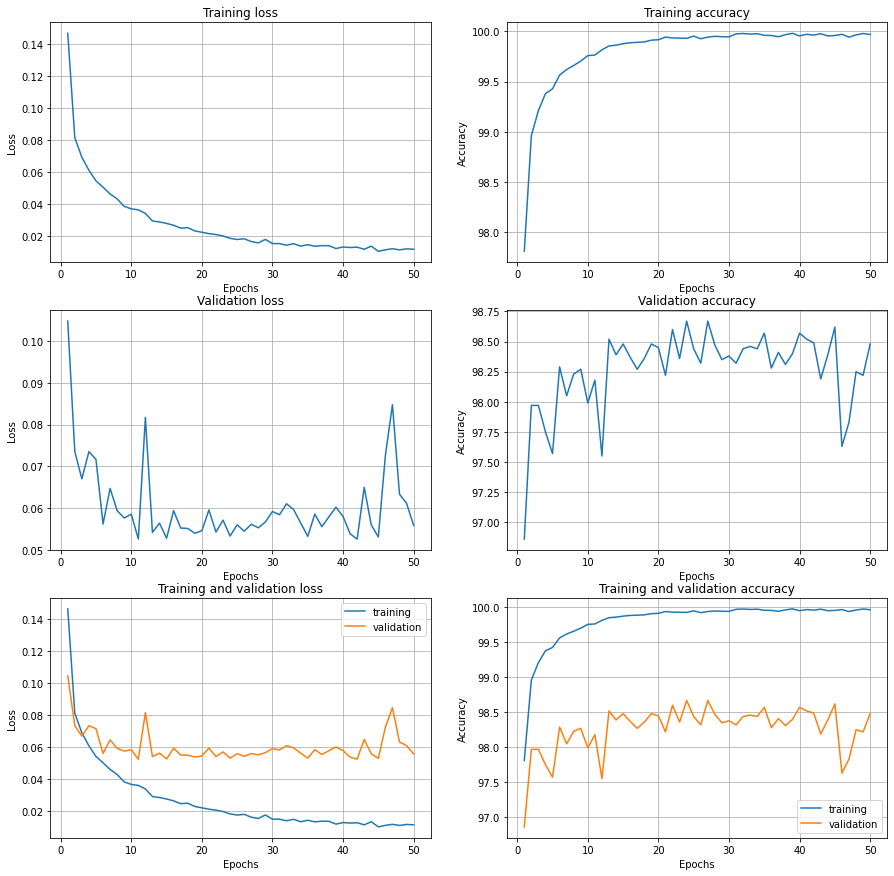

In [ ]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [ ]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

Maximum accuracy of the network for the training images 99.980000 % at epoch 39
Maximum accuracy of the network for the validation images 98.670000 % at epoch 24


In [ ]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy of the network for the training images: 99.79 %


In [ ]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)

# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the validation images: 98.42 %
Per class accuracy tensor([0.9807, 0.9923, 0.9845, 0.9951, 0.9672])


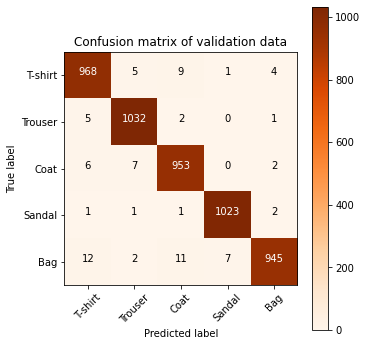

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [ ]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the test images: 98.64 %
Loss : 0.055
Per class accuracy tensor([0.9680, 0.9920, 0.9950, 1.0000, 0.9770])


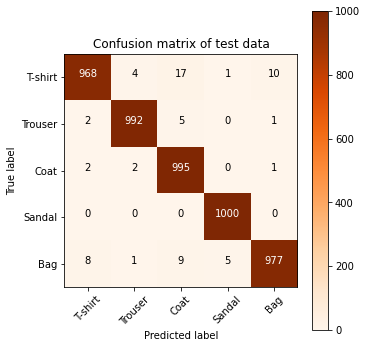

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [ ]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy of class 0 : 97.98 %
Accuracy of class 1 : 98.97 %
Accuracy of class 2 : 100.00 %
Accuracy of class 3 : 100.00 %
Accuracy of class 4 : 97.22 %


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


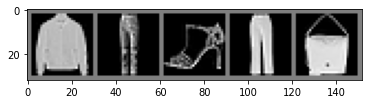

  Correct Label:      2     1     3     1     4
Predicted Label:      2     1     3     1     4


In [ ]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))

# Fourteenth Test:
- Optimizer = RMSProp w/ momentum
- Activation = tanh
- Epochs = 50
- Learning rate = 0.001
- Momentum = 0.9
- Drop out = 0.25
- Regularisation = 0.0002

In [ ]:
# Create the CNN
net = Neural_Network()

# Define the hyperparameters
optimizer = 'RMSProp'
activation = 'tanh'
no_epochs = 50
lr = 0.001
momentum = 0.9
reg = 0.0002


# Train the CNN
net.train_valid_net(trainloader, validloader, no_epochs, lr, optimizer, activation, momentum, reg_coeff = reg)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[Epoch: 1 Images in batch:   500] loss: 0.210
[Epoch: 1 Images in batch:   100] loss: 0.146
[Epoch: 2 Images in batch:   500] loss: 0.147
[Epoch: 2 Images in batch:   100] loss: 0.146
[Epoch: 3 Images in batch:   500] loss: 0.135
[Epoch: 3 Images in batch:   100] loss: 0.128
[Epoch: 4 Images in batch:   500] loss: 0.127
[Epoch: 4 Images in batch:   100] loss: 0.121
[Epoch: 5 Images in batch:   500] loss: 0.126
[Epoch: 5 Images in batch:   100] loss: 0.129
[Epoch: 6 Images in batch:   500] loss: 0.126
[Epoch: 6 Images in batch:   100] loss: 0.123
[Epoch: 7 Images in batch:   500] loss: 0.126
[Epoch: 7 Images in batch:   100] loss: 0.133
[Epoch: 8 Images in batch:   500] loss: 0.121
[Epoch: 8 Images in batch:   100] loss: 0.123
[Epoch: 9 Images in batch:   500] loss: 0.120
[Epoch: 9 Images in batch:   100] loss: 0.148
[Epoch: 10 Images in batch:   500] loss: 0.117
[Epoch: 10 Images in batch:   100] loss: 0.138
[Epoch: 11 Images in batch:   500] loss: 0.117
[Epoch: 11 Images in batch:   1

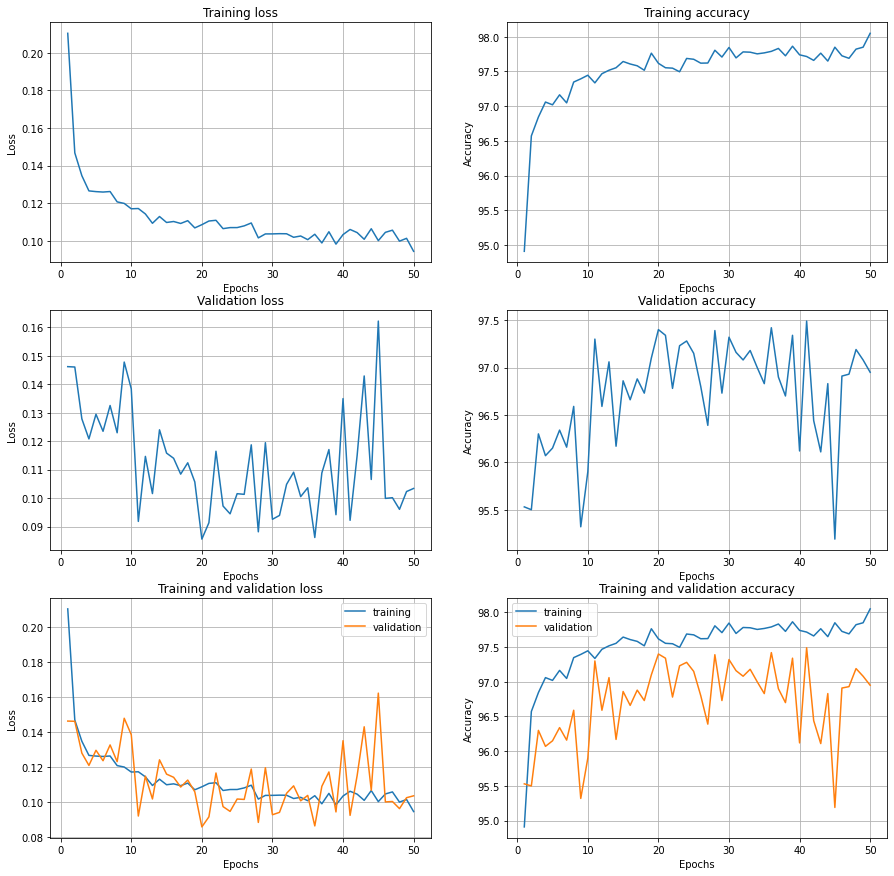

In [ ]:
create_directory()

# Plot the training and validation loss and accuracy
training_loss = net.losses
training_accuracy = net.accuracies
validation_loss = net.validlosses
validation_accuracy = net.validaccuracies
epoch_tracker = net.epoch_track

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_tracker, training_loss)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_tracker, training_accuracy)
axs[0,1].set_title("Training accuracy")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Accuracy")

axs[1,0].plot(epoch_tracker, validation_loss)
axs[1,0].set_title("Validation loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,1].plot(epoch_tracker, validation_accuracy)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[2,0].plot(epoch_tracker, training_loss)
axs[2,0].plot(epoch_tracker, validation_loss)
axs[2,0].set_title("Training and validation loss")
legend = ["training","validation"]
axs[2,0].legend(legend)
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Loss")

axs[2,1].plot(epoch_tracker, training_accuracy)
axs[2,1].plot(epoch_tracker, validation_accuracy)
axs[2,1].set_title("Training and validation accuracy")
legend = ["training","validation"]
axs[2,1].legend(legend)
axs[2,1].set_xlabel("Epochs")
axs[2,1].set_ylabel("Accuracy")

plt.savefig('./Saved_Train_Accuracy_Images/training_val_loss_accuracy.png')

axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

In [ ]:
# Calculate the maximum accuracy for the training and validation sets
max_train_accuracy = np.max(training_accuracy)
max_valid_accuracy = np.max(validation_accuracy)
print("Maximum accuracy of the network for the training images %f %%" % max_train_accuracy, "at epoch", training_accuracy.index(max_train_accuracy)+1)
print("Maximum accuracy of the network for the validation images %f %%" % max_valid_accuracy, "at epoch", validation_accuracy.index(max_valid_accuracy)+1)

Maximum accuracy of the network for the training images 98.050000 % at epoch 50
Maximum accuracy of the network for the validation images 97.490000 % at epoch 41


In [ ]:
train_correct_pred = 0
train_total_pred = 0

for trainset in trainloader:
    train_images, train_labels = trainset
    train_outputs = net.forward(Variable(train_images), activation)
    train_dummy, train_predicted_labels = torch.max(train_outputs.data, 1)
    train_correct_pred += (train_predicted_labels == train_labels).sum()
    train_total_pred += train_predicted_labels.size(0)

print('Accuracy of the network for the training images: %.2f %%' 
      % ( 100 * train_correct_pred / train_total_pred))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy of the network for the training images: 97.36 %


In [ ]:
valid_correct_pred = 0
valid_total_pred = 0

confusion_matrix_valid = torch.zeros(5, 5) # Set up confusion matrix

for validset in validloader:
    valid_images, valid_labels = validset
    valid_outputs = net.forward(Variable(valid_images), activation, p = False)
    valid_dummy, valid_predicted_labels = torch.max(valid_outputs.data, 1)
    valid_correct_pred += (valid_predicted_labels == valid_labels).sum()
    valid_total_pred += valid_predicted_labels.size(0)

# Fill in confusion matrix
    for l, p in zip(valid_labels.view(-1), valid_predicted_labels.view(-1)):
                confusion_matrix_valid[l.long(), p.long()] += 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_valid_np = confusion_matrix_valid.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the validation images: 96.64 %
Per class accuracy tensor([0.9493, 0.9837, 0.9566, 0.9854, 0.9550])


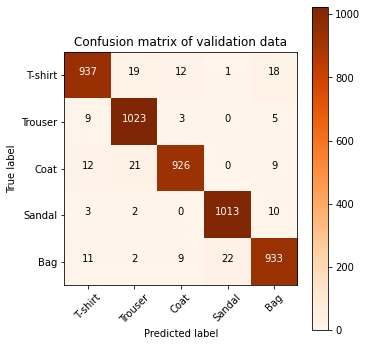

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_valid_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of validation data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_valid_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_valid_np.shape[0]), range(confusion_matrix_valid_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_valid_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_valid_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the validation images: %.2f %%' 
      % ( 100 * valid_correct_pred / valid_total_pred))

print("Per class accuracy", confusion_matrix_valid.diag()/confusion_matrix_valid.sum(1))

In [ ]:
# Calculate the classification accuracy for the entire test set
test_correct_pred = 0
test_total_pred = 0
test_current_loss = 0.0
loss_func = nn.CrossEntropyLoss()

confusion_matrix_test = torch.zeros(5, 5) # Setup confusion matrix

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)
    test_correct_pred += (test_predicted_labels == test_labels).sum()
    test_total_pred += test_predicted_labels.size(0)
    test_loss = loss_func(test_outputs, test_labels)
    test_current_loss += test_loss.item()

# Fill in confusion matrix
    for l, p in zip(test_labels.view(-1), test_predicted_labels.view(-1)):
                confusion_matrix_test[l.long(), p.long()] += 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
# Convert confustion matrix to numpy array
confusion_matrix_test_np = confusion_matrix_test.numpy()

# Create array of labels
labels_list = np.array(["T-shirt","Trouser","Coat","Sandal","Bag"])

Accuracy of the network for the test images: 97.14 %
Loss : 0.101
Per class accuracy tensor([0.9560, 0.9900, 0.9660, 0.9940, 0.9510])


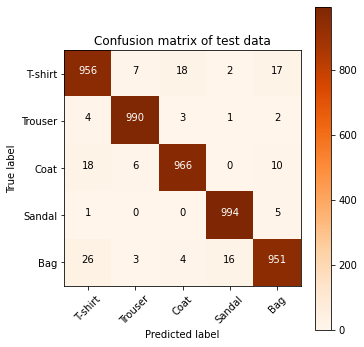

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test_np, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion matrix of test data")
plt.colorbar()
tick_marks = np.arange(len(labels_list))
plt.xticks(tick_marks, labels_list, rotation=45)
plt.yticks(tick_marks, labels_list)

fmt = '.0f'
thresh = confusion_matrix_test_np.max() / 2.
for i, j in itertools.product(range(confusion_matrix_test_np.shape[0]), range(confusion_matrix_test_np.shape[1])):
        plt.text(j, i, format(confusion_matrix_test_np[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix_test_np[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Accuracy of the network for the test images: %.2f %%' 
      % ( 100 * test_correct_pred / test_total_pred))

print('Loss : %.3f' % (test_current_loss / len(testloader)))

print("Per class accuracy", confusion_matrix_test.diag()/confusion_matrix_test.sum(1))

In [ ]:
# Calculate the classification accuracy for each object class

test_classes = np.array([0, 1, 2, 3, 4])

test_class_correct = list(0. for i in range(5))
test_class_total = list(0. for i in range(5))

for testset in testloader:
    test_images, test_labels = testset
    test_outputs = net.forward(Variable(test_images), activation, p = False)
    test_dummy, test_pred_labels = torch.max(test_outputs.data, 1)
    test_correct = (test_pred_labels == test_labels).squeeze()
    
    #for i in range(5):
    for i in test_classes:
        test_label = test_labels[i]
        test_class_correct[test_label] += test_correct[i]
        test_class_total[test_label] +=1

#for i in range(5):
for i in test_classes:
    print('Accuracy of class %d : %.2f %%' % ( i, 
                                             100 * test_class_correct[i].item()/test_class_total[i]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy of class 0 : 98.17 %
Accuracy of class 1 : 97.89 %
Accuracy of class 2 : 98.10 %
Accuracy of class 3 : 100.00 %
Accuracy of class 4 : 100.00 %


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


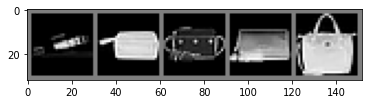

  Correct Label:      3     4     4     4     4
Predicted Label:      3     4     4     4     4


In [ ]:
# Pick a random batch & extract the corect labels
data_iterator = iter(testloader)
test_images, test_correct_labels = data_iterator.next()

# Compute the predicted label
test_outputs = net.forward(Variable(test_images), activation, p = False)
test_dummy, test_predicted_labels = torch.max(test_outputs.data, 1)

show_image(torchvision.utils.make_grid(test_images[0:5], 5))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % test_correct_labels[j].item() for j in test_classes))
print('Predicted Label: ', ' '.join('%5s' % test_predicted_labels[j].item() for j in test_classes))